In [3]:
import folium
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
europe_data_path =  os.path.join('data', 'tepsr_wc170.tsv')
europe_data_original = pd.DataFrame.from_csv(europe_data_path, sep='\t')


europe_data = europe_data_original.copy()

# Keeps only digits and dots from a string
def clean_number(n):
    return ''.join(c for c in str(n) if c.isdigit() or c == '.')

# Keep only rows for age group 20-64 and drop other age ranges
europe_data = europe_data.filter(regex='^PC,T,Y20-64,TOTAL', axis=0)

# Clean the values, as some contain letters
europe_data = europe_data.applymap(lambda x: clean_number(x))

# Rename the indexes to keep only the country code
europe_data.index = europe_data.index.to_series().str.replace(r'PC,T,Y20-64,TOTAL,(\w+)', r'\1')
europe_data.index.name = 'country_code'

# Keep only the 2016 column, which is the most recent data
europe_data = europe_data[['2016 ']]

# Useless below?
europe_data = europe_data.fillna('0.0').astype('float')

europe_data = europe_data.head(1)

europe_data.head()

,2016
country_code,
AT,5.8


In [5]:
#europe_topojson_path = os.path.join('topojson', 'europe.topojson.json')
europe_topojson_path = os.path.join('topojson', 'europe.geojson')

europe_topojson = json.load(open(europe_topojson_path))
europe_map = folium.Map(
    location=[53.5775, 23.106111],
    tiles='cartodbpositron',
    #tiles='Mapbox Bright',
    zoom_start=4
)

folium.GeoJson(europe_topojson).add_to(europe_map)

europe_map.choropleth(geo_data=europe_topojson, data=europe_data,
                   columns=['2016 '],
                   key_on='features.properties.FIPS',
                   fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                   legend_name='Unemployment rate')

europe_map

IndexError: list index out of range

### Part 3
Assumptions:
 - Unemployement rate = ( number of unemployed people / nuber of active population ) * 100
 - Unemployed people age 25 and above registered in ORP (recent graduates are not included) ( includes people looking for a job)
 - Active population includes all people working at least one hour per week or not.
 

In order to facilitate our work with the topoJSON file later on, we start with the data file in German. Moreover this file contains data for the whole past year. However we are going to keep track of most recent month, assuming that the interest of the stuty is to observe and conclude upon current situation. However we do take a look at general year dynamic later on.

In [7]:
# Load the data
suisse_nat_xls_data_path =  os.path.join('data', '2_1_Arbeitslosenquoten.xlsx')
suisse_nat = pd.read_excel(suisse_nat_xls_data_path, sheetname='2.1 Arbeitslosenquoten', header=5)
# Clean up some useless columns
suisse_nat.drop(['Monat'], axis=1, inplace = True)
suisse_nat.drop(['Gesamt'], axis=1, inplace = True)
suisse_nat.head(5)

,Kanton,Nationalität,September 2016,Oktober 2016,November 2016,Dezember 2016,Januar 2017,Februar 2017,März 2017,April 2017,Mai 2017,Juni 2017,Juli 2017,August 2017,September 2017
0,Zürich,Ausländer,5.7,5.8,6.1,6.4,6.6,6.5,6.3,6.0,5.7,5.6,5.5,5.3,5.3
1,Zürich,Schweizer,2.8,2.8,2.8,2.9,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5
2,Bern,Ausländer,5.9,6.3,6.9,7.3,7.5,7.4,7.1,6.8,6.2,5.7,5.5,5.5,5.5
3,Bern,Schweizer,2.0,2.0,2.0,2.1,2.2,2.1,2.1,2.0,1.9,1.8,1.8,1.9,1.8
4,Luzern,Ausländer,4.2,4.2,4.6,5.1,5.4,5.1,4.8,4.6,4.3,4.1,3.9,3.9,3.9


Now that the data is in good shape let's see if any formating is required.

In [8]:
suisse_nat.dtypes

Kanton             object
Nationalität       object
September 2016    float64
Oktober 2016      float64
November 2016     float64
Dezember 2016     float64
Januar 2017       float64
Februar 2017      float64
März 2017         float64
April 2017        float64
Mai 2017          float64
Juni 2017         float64
Juli 2017         float64
August 2017       float64
September 2017    float64
dtype: object

Formats look good. However there is the last row for the total unemployment rate accross Switzerland, for now we'll keep it, but further on, we should discart it.

In [9]:
suisse_nat.tail(3)

,Kanton,Nationalität,September 2016,Oktober 2016,November 2016,Dezember 2016,Januar 2017,Februar 2017,März 2017,April 2017,Mai 2017,Juni 2017,Juli 2017,August 2017,September 2017
50,Jura,Ausländer,10.2,10.2,10.4,11.5,11.9,11.5,10.7,10.0,9.5,9.4,9.5,9.5,9.0
51,Jura,Schweizer,3.6,3.6,3.6,3.9,4.1,4.1,3.8,3.7,3.5,3.4,3.4,3.8,3.6
52,Gesamt,NaN,3.2,3.2,3.3,3.5,3.7,3.6,3.4,3.3,3.1,3.0,3.0,3.0,3.0


In [10]:
# Here we create a version with unique hierarchical index, it turned out to be useless at the end.
suisse_nat_hier = suisse_nat.copy()
suisse_nat_hier = suisse_nat_hier.set_index(['Kanton', 'Nationalität'])
suisse_nat_hier.head(5)

September 2016  Oktober 2016  November 2016  \
Kanton Nationalität                                                
Zürich Ausländer                5.7           5.8            6.1   
       Schweizer                2.8           2.8            2.8   
Bern   Ausländer                5.9           6.3            6.9   
       Schweizer                2.0           2.0            2.0   
Luzern Ausländer                4.2           4.2            4.6   

                     Dezember 2016  Januar 2017  Februar 2017  März 2017  \
Kanton Nationalität                                                        
Zürich Ausländer               6.4          6.6           6.5        6.3   
       Schweizer               2.9          2.9           2.8        2.8   
Bern   Ausländer               7.3          7.5           7.4        7.1   
       Schweizer               2.1          2.2           2.1        2.1   
Luzern Ausländer               5.1          5.4           5.1        4.8   

                     April 2017  Mai 2017  Juni 2017  Juli 2017  August 2017  \
Kanton Nationalität                                                            
Zürich Ausländer            6.0       5.7        5.6        5.5          5.3   
       Schweizer            2.7       2.6        2.6        2.6          2.6   
Bern   Ausländer            6.8       6.2        5.7        5.5          5.5   
       Schweizer            2.0       1.9        1.8        1.8          1.9   
Luzern Ausländer            4.6       4.3        4.1        3.9          3.9   

                     September 2017  
Kanton Nationalität                  
Zürich Ausländer                5.3  
       Schweizer                2.5  
Bern   Ausländer                5.5  
       Schweizer                1.8  
Luzern Ausländer                3.9

Now here is the interesting part. The names of cantons in the topoJSON file are given in French, Italian and German. This makes it hard to match our data to the geometries on the graph. Our strategy is to build a dictionary from canton names in German (in our data) to the canton names in languages in topoJSON file. There are little optimizations such as reducing the set of names to match to as we go. Eventhough this technique is relatively successful, there are a couple of exceptions that need to be dealt with manulaly.

In [15]:
import difflib
suisse_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')
suisse_topojson = json.load(open(suisse_topojson_path))
cantonNames = []
for name in suisse_topojson['objects']['cantons']['geometries']:
    cantonNames.append(name['properties']['name'])
    #cantons.append(name)
cantonNames
#Get index of canton, get canton, compare to all, put the other one
cantonTranslation = []
cantonSeen = []
# append exceptions
cantonTranslation.append(('Waadt', 'Vaud'))
cantonTranslation.append(('Neuenburg', 'Neuchâtel'))
cantonTranslation.append(('Gesamt', 'Gesamt'))
cantons = suisse_nat.Kanton.copy()
cantons.drop_duplicates(inplace=True)
for canton1 in cantons:
    max = 0
    match
    a = canton1.lower()
    a = a.split('/')[0]
    if ((a != 'waadt') & (a != 'neuenburg') & (a != 'gesamt')):
        for canton2 in cantonNames:
            b = canton2.lower()
            b = b.split('/')[0]
            seq=difflib.SequenceMatcher(None, a, b)
            diff = seq.ratio()
            if max < diff:
                max = diff
                match = (canton1, canton2)
        cantonNames.remove(match[1])
    cantonTranslation.append(match)
cantonTranslationDict = dict(cantonTranslation)
print(cantonTranslationDict)

{'Waadt': 'Vaud', 'Neuenburg': 'Neuchâtel', 'Gesamt': 'Gesamt', 'Zürich': 'Zürich', 'Bern': 'Bern/Berne', 'Luzern': 'Luzern', 'Uri': 'Uri', 'Schwyz': 'Schwyz', 'Obwalden': 'Obwalden', 'Nidwalden': 'Nidwalden', 'Glarus': 'Glarus', 'Zug': 'Zug', 'Freiburg': 'Fribourg', 'Solothurn': 'Solothurn', 'Basel-Stadt': 'Basel-Stadt', 'Basel-Landschaft': 'Basel-Landschaft', 'Schaffhausen': 'Schaffhausen', 'Appenzell Ausserrhoden': 'Appenzell Ausserrhoden', 'Appenzell Innerrhoden': 'Appenzell Innerrhoden', 'St. Gallen': 'St. Gallen', 'Graubünden': 'Graubünden/Grigioni', 'Aargau': 'Aargau', 'Thurgau': 'Thurgau', 'Tessin': 'Ticino', 'Wallis': 'Valais/Wallis', 'Genf': 'Genève', 'Jura': 'Jura'}


Now that we have a dictionary, we can replace the names of cantons in the main dataFrame.

In [16]:
suisse_nat["Kanton"] = suisse_nat["Kanton"].replace(cantonTranslationDict, inplace=False)
suisse_nat.tail(10)

,Kanton,Nationalität,September 2016,Oktober 2016,November 2016,Dezember 2016,Januar 2017,Februar 2017,März 2017,April 2017,Mai 2017,Juni 2017,Juli 2017,August 2017,September 2017
43,Vaud,Schweizer,3.6,3.6,3.6,3.7,3.8,3.7,3.6,3.5,3.4,3.4,3.5,3.6,3.5
44,Valais/Wallis,Ausländer,6.0,6.4,7.9,11.9,12.2,10.5,8.3,7.7,6.3,5.2,5.0,5.1,4.9
45,Valais/Wallis,Schweizer,2.3,2.3,2.4,2.8,2.8,2.7,2.4,2.3,2.3,2.1,2.2,2.2,2.1
46,Neuchâtel,Ausländer,8.7,8.6,9.1,10.4,10.7,10.5,9.8,9.0,8.4,7.6,7.6,7.5,7.4
47,Neuchâtel,Schweizer,4.6,4.6,4.6,4.7,4.9,4.9,4.7,4.6,4.4,4.2,4.3,4.3,4.2
48,Genève,Ausländer,6.2,6.3,6.2,6.3,6.5,6.4,6.2,6.0,5.9,5.8,5.7,5.7,5.7
49,Genève,Schweizer,5.0,5.0,4.9,4.9,5.0,4.8,4.8,4.7,4.6,4.6,4.7,4.8,4.8
50,Jura,Ausländer,10.2,10.2,10.4,11.5,11.9,11.5,10.7,10.0,9.5,9.4,9.5,9.5,9.0
51,Jura,Schweizer,3.6,3.6,3.6,3.9,4.1,4.1,3.8,3.7,3.5,3.4,3.4,3.8,3.6
52,Gesamt,NaN,3.2,3.2,3.3,3.5,3.7,3.6,3.4,3.3,3.1,3.0,3.0,3.0,3.0


Now let's see if there is anything interesting in the change of unemplyment over the year.

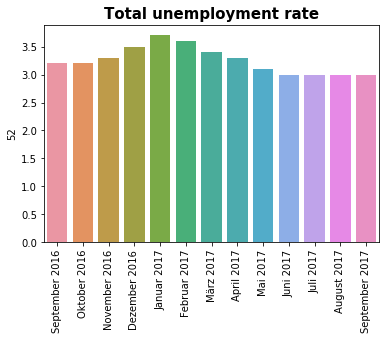

In [17]:
suisse_nat_copy = suisse_nat.copy()
suisse_nat_copy.drop(['Kanton'], axis=1, inplace = True)
suisse_nat_copy.drop(['Nationalität'], axis=1, inplace = True)
#suisse_nat_copy.drop(['Gesamt'], axis=1, inplace = True)
fig, ax = plt.subplots()
ax.set_title('Total unemployment rate', fontsize=15, fontweight='bold')
sns.barplot(suisse_nat_copy.iloc[52].keys(), suisse_nat_copy.iloc[52], ax=ax)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()
#suisse_nat_copy[:10].keys()

It appears that the highest unemployment is in January. Hmmm... Our guess is that it's because all the shor-term contracts are done at that point in the year. To check this theory we need to look at the number of short-term contracters entering unemployment monthly. We leave that to a separate work.

Now let's get back to building maps for September 2017.

In [18]:
suisse_nat_copy.keys()

Index(['September 2016', 'Oktober 2016', 'November 2016', 'Dezember 2016',
       'Januar 2017', 'Februar 2017', 'März 2017', 'April 2017', 'Mai 2017',
       'Juni 2017', 'Juli 2017', 'August 2017', 'September 2017'],
      dtype='object')

First we tried to display only Switzerland and find a good stating point.

In [19]:
suisse_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')
suisse_topojson = json.load(open(suisse_topojson_path))
suisse_map = folium.Map(
    location=[46.800, 8.3093],
    tiles='cartodbpositron',
    #tiles='Mapbox Bright',
    zoom_start=8
)   
#folium.TopoJson(suisse_topojson).add_to(suisse_map)
suisse_map

Now let's superpose the topoJSON file.

In [20]:
suisse_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')
suisse_topojson = json.load(open(suisse_topojson_path))
results_map = folium.Map(
    location=[46.800, 8.3093],
    tiles='cartodbpositron',
    #tiles='Mapbox Bright',
    zoom_start=8
)

folium.TopoJson(
    open(suisse_topojson_path),
    'objects.cantons',
    name='topojson'
).add_to(results_map)

folium.LayerControl().add_to(results_map)

results_map

Since we sre going to draw a couple of maps, let's make a function that would take in the nationality, month and boolean parameter and build the choropleth map. The boolean parameter is used to define the scale. We've tried with D3 threshold scale and quantized split_six. Even though the later one is supposed to be better, we found the result of the first one more expressive.

In [21]:
from branca.utilities import split_six

def showmap(nationality, month, splitSix):
    # Let's prepare the dataframe
    suisse_nat_ger_sept = suisse_nat.copy()
    suisse_nat_ger_sept = suisse_nat_ger_sept[suisse_nat_ger_sept.Nationalität == nationality]
    suisse_nat_ger_sept = suisse_nat_ger_sept[['Kanton', month]]
    # Let's plot a little barchart to see which scale makes sense
    suisse_nat_ger_sept_bar = suisse_nat_ger_sept.copy()
    suisse_nat_ger_sept_bar.index = suisse_nat_ger_sept_bar.Kanton
    #suisse_nat_ger_sept_bar.plot.bar()
    suisse_nat_ger_sept_bar.plot.hist()
    plt.show()
    # Now we can load the topoJSON file where the names of the cantons should match
    suisse_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')
    results_map = folium.Map(
        location=[46.800, 8.3093],
        tiles='cartodbpositron',
        #tiles='Mapbox Bright',
        zoom_start=8
    )
    # Just in case let's define the split_six threshold
    threshold_scale = split_six(suisse_nat_ger_sept[month])
    # Finaly we construct the map with standart linear or split_six threshold
    if splitSix :
        results_map.choropleth(
            open(suisse_topojson_path),
            data=suisse_nat_ger_sept,
            columns=['Kanton',month],
            key_on='feature.properties.name',
            topojson='objects.cantons',
            fill_color='BuPu',
            fill_opacity=0.7,
            line_opacity=0.5,
            legend_name=(nationality + ' Unemployment Rate (%)'),
            threshold_scale=threshold_scale,
            reset=True
        )
    else:
        results_map.choropleth(
            open(suisse_topojson_path),
            data=suisse_nat_ger_sept,
            columns=['Kanton',month],
            key_on='feature.properties.name',
            topojson='objects.cantons',
            fill_color='BuPu',
            fill_opacity=0.7,
            line_opacity=0.5,
            legend_name=(nationality + ' Unemployment Rate (%)'),
            #threshold_scale=threshold_scale,
            reset=True
        )

    folium.LayerControl().add_to(results_map)
    
    results_map.save('data/' + month + nationality + str(splitSix) + 'map.html')

    return results_map

#### Tryout with split_six threshhold, Unemplyment of Swiss people over 24

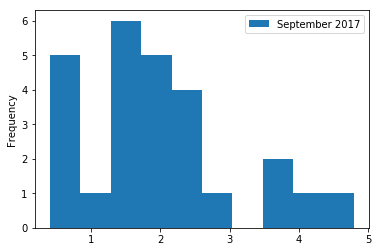

In [22]:
showmap("Schweizer", 'September 2017', True)

#### Map of Swiss people unemplyment, linear scale

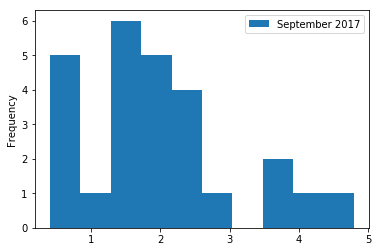

In [23]:
showmap("Schweizer", 'September 2017', False)

#### Non-swiss people unemployment, linear scale

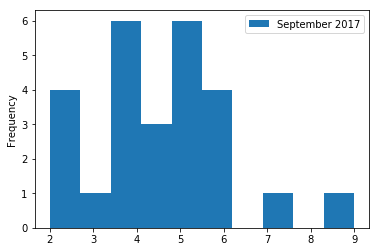

In [24]:
showmap("Ausländer", 'September 2017', False)

One way to display all the rates over the year is to make an interactive map that changes to show data for given month and nationality. Feel free to change any parameter.

In [25]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

monthChoice = widgets.Dropdown(
    options=suisse_nat_copy.keys(),
    value='September 2017',
    description='Month:',
    disabled=False,
)

nationalityChoice = widgets.RadioButtons(
    options=["Schweizer", "Ausländer"],
    value="Schweizer",
    description='Nationality:',
    disabled=False
)

thresholdChoice = widgets.Checkbox(
    value=False,
    description='Use split_six threshold',
    disabled=False
)

#display(monthChoice)
#display(nationalityChoice)
interact(showmap, nationality = nationalityChoice, month = monthChoice, splitSix = thresholdChoice)


interactive(children=(RadioButtons(description='Nationality:', options=('Schweizer', 'Ausländer'), value='Schweizer'), Dropdown(description='Month:', index=12, options=('September 2016', 'Oktober 2016', 'November 2016', 'Dezember 2016', 'Januar 2017', 'Februar 2017', 'März 2017', 'April 2017', 'Mai 2017', 'Juni 2017', 'Juli 2017', 'August 2017', 'September 2017'), value='September 2017'), Checkbox(value=False, description='Use split_six threshold'), Output()), _dom_classes=('widget-interact',))

<function __main__.showmap>

Now that we have the basic way of displaying the data with two maps done. Let's think how can we show the difference in uneployment based on nationality. One way could be the difference, however, looking at the data, that is not very promissing as it would be very small. Instead let's think back to the definition of unemplyment rate: it's the amount of unemployed people of that nationality per 100 active people of that nationality. Such definition gets rid of the bias due to increased ammount of Swiss people to non-Swiss people. Therefore we can compare the unemployment rates as ratio of one to another. That is to how many non-Swiss unemplyed people per 100 non-Swiss correponds one Swiss unemployed person in a hundred Swiss people. It is a hard metric to grasp but we find the final result to be demonstative. The drawback of this method is that it won't work if the non-Swiss unemployment is zero, but first of all, looking at the data it never is zero through out the year and also full employment has been proven imposible in economics. Another drawback is that the range for ratio under one is smaller then the range for over one. In our case Swiss unemployment is always smaller then the non-Swiss unemployment, therefore in this particular case, it is not a concern. Otherwise, as in a more general usage we can assume that quantile scale would take care of this drawback while displaying the data.

In [31]:
suisse_nat_ger_sept_sw = suisse_nat.copy()
suisse_nat_ger_sept_sw = suisse_nat_ger_sept_sw[suisse_nat_ger_sept_sw.Nationalität == "Schweizer"]
suisse_nat_ger_sept_sw = suisse_nat_ger_sept_sw[['Kanton', 'September 2017']]
suisse_nat_ger_sept_sw.head(5)

,Kanton,September 2017
1,Zürich,2.5
3,Bern/Berne,1.8
5,Luzern,1.3
7,Uri,0.4
9,Schwyz,1.2


In [32]:
suisse_nat_ger_sept_a = suisse_nat.copy()
suisse_nat_ger_sept_a = suisse_nat_ger_sept_a[suisse_nat_ger_sept_a.Nationalität == "Ausländer"]
suisse_nat_ger_sept_a = suisse_nat_ger_sept_a[['Kanton', 'September 2017']]
suisse_nat_ger_sept_a.head(5)

,Kanton,September 2017
0,Zürich,5.3
2,Bern/Berne,5.5
4,Luzern,3.9
6,Uri,2.1
8,Schwyz,3.4


In [33]:
suisse_nat_ger_sept_a.Sept2017A = suisse_nat_ger_sept_a['September 2017']
suisse_nat_ger_sept_a.head(5)

,Kanton,September 2017
0,Zürich,5.3
2,Bern/Berne,5.5
4,Luzern,3.9
6,Uri,2.1
8,Schwyz,3.4


In [34]:
suisse_nat_ger_sept_ratio = pd.merge(suisse_nat_ger_sept_a, suisse_nat_ger_sept_sw, on='Kanton')
suisse_nat_ger_sept_ratio.head(5)

,Kanton,September 2017_x,September 2017_y
0,Zürich,5.3,2.5
1,Bern/Berne,5.5,1.8
2,Luzern,3.9,1.3
3,Uri,2.1,0.4
4,Schwyz,3.4,1.2


In [35]:
suisse_nat_ger_sept_ratio['Ratio'] = suisse_nat_ger_sept_ratio['September 2017_x'] / suisse_nat_ger_sept_ratio['September 2017_y']
suisse_nat_ger_sept_ratio.head(5)

,Kanton,September 2017_x,September 2017_y,Ratio
0,Zürich,5.3,2.5,2.120000
1,Bern/Berne,5.5,1.8,3.055556
2,Luzern,3.9,1.3,3.000000
3,Uri,2.1,0.4,5.250000
4,Schwyz,3.4,1.2,2.833333


In [36]:
suisse_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')
results_map = folium.Map(
    location=[46.800, 8.3093],
    tiles='cartodbpositron',
    #tiles='Mapbox Bright',
    zoom_start=8
)

#threshold_scale = split_six(suisse_nat_ger_sept[month])

results_map.choropleth(
    open(suisse_topojson_path),
    data=suisse_nat_ger_sept_ratio,
    columns=['Kanton','Ratio'],
    key_on='feature.properties.name',
    topojson='objects.cantons',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Unemployment Ratio of non-Swiss people unemp. to Swiss people unemp.',
    #threshold_scale=threshold_scale,
    reset=True
)

folium.LayerControl().add_to(results_map)

results_map.save('data/ratioMap.html')

results_map

As a result we can see that more internationally friendly cantons such as Vaud, Geneva and Zurich emply more non-Swiss people and so the ratio is closer to 1. However it is much harder for international people to find work in more rural parts of Switzerland.

### Now let's have a look at the age groups
Due to the format of data on the Amstat website, we decided to choose the standart age separation as young (15 - 24) and aged (25 - above). It appears that these are clean-cut two different categories that are not mixed up in the unemployment rate calculation, and so make sense to be separated as age groups.

First let's start by loading the data.

In [37]:
suisse_jeunes_xls_data_path =  os.path.join('data', '2_2_Taux_de_ch%C3%B4mage des jeunes.xlsx')
suisse_nat_jeunes = pd.read_excel(suisse_jeunes_xls_data_path, sheetname='2.2 Taux de chômage des jeunes', header=3)
suisse_nat_jeunes.drop(['Mois'], axis=1, inplace = True)
suisse_nat_jeunes.head(5)

Septembre 2017
Zurich  Etrangers            5.8
        Suisses              3.2
Berne   Etrangers            7.7
        Suisses              2.2
Lucerne Etrangers            4.7

It needs osme cleaning and reaindexing to look like the data for aged people.

In [38]:
suisse_nat_jeunes = suisse_nat_jeunes.reset_index()
suisse_nat_jeunes['Canton'] = suisse_nat_jeunes['level_0']
suisse_nat_jeunes.drop(['level_0'], axis=1, inplace = True)
suisse_nat_jeunes['Septembre 2017'].replace('...', np.nan, inplace = True)
suisse_nat_jeunes['Septembre 2017'] = pd.to_numeric(suisse_nat_jeunes['Septembre 2017'])
suisse_nat_jeunes.dtypes

level_1            object
Septembre 2017    float64
Canton             object
dtype: object

In [39]:
suisse_nat_jeunes.head(5)

,level_1,Septembre 2017,Canton
0,Etrangers,5.8,Zurich
1,Suisses,3.2,Zurich
2,Etrangers,7.7,Berne
3,Suisses,2.2,Berne
4,Etrangers,4.7,Lucerne


Now let's extract the data we are actually interested in and prepare it for merging.

In [40]:
suisse_nat_young_swiss = suisse_nat_jeunes[suisse_nat_jeunes.level_1 == 'Suisses']
suisse_nat_young_swiss = suisse_nat_young_swiss[['Canton', 'Septembre 2017']]
suisse_nat_young_swiss['Suisses_Young'] = suisse_nat_young_swiss['Septembre 2017']
suisse_nat_young_swiss.drop(['Septembre 2017'], axis=1, inplace = True)
suisse_nat_young_swiss.head(5)

,Canton,Suisses_Young
1,Zurich,3.2
3,Berne,2.2
5,Lucerne,1.7
7,Uri,0.3
9,Schwyz,1.2


In [41]:
suisse_nat_young_non_swiss = suisse_nat_jeunes[suisse_nat_jeunes.level_1 == 'Etrangers']
suisse_nat_young_non_swiss = suisse_nat_young_non_swiss[['Canton', 'Septembre 2017']]
suisse_nat_young_non_swiss['Etranger_Young'] = suisse_nat_young_non_swiss['Septembre 2017']
suisse_nat_young_non_swiss.drop(['Septembre 2017'], axis=1, inplace = True)
suisse_nat_young_non_swiss.head(5)

,Canton,Etranger_Young
0,Zurich,5.8
2,Berne,7.7
4,Lucerne,4.7
6,Uri,NaN
8,Schwyz,3.5


In [42]:
suisse_nat_young_merged = pd.merge(suisse_nat_young_non_swiss, suisse_nat_young_swiss, on='Canton')
suisse_nat_young_merged.head(5)

,Canton,Etranger_Young,Suisses_Young
0,Zurich,5.8,3.2
1,Berne,7.7,2.2
2,Lucerne,4.7,1.7
3,Uri,NaN,0.3
4,Schwyz,3.5,1.2


Now we do similar procedure to the aged people data. It is a bit different and not missing any values.

In [43]:
suisse_nat_aged_xls_data_path =  os.path.join('data', '2_1_Taux_de_ch_clean.xlsx')
suisse_nat_aged = pd.read_excel(suisse_nat_aged_xls_data_path, sheetname='2.1 Taux de chômage', header=5)
suisse_nat_aged.drop(['Mois'], axis=1, inplace = True)
suisse_nat_aged.drop(['Total'], axis=1, inplace = True)
suisse_nat_aged.head(5)

,Canton,Nationalité,Septembre 2016,Octobre 2016,Novembre 2016,Décembre 2016,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017
0,Zurich,Etrangers,5.7,5.8,6.1,6.4,6.6,6.5,6.3,6.0,5.7,5.6,5.5,5.3,5.3
1,Zurich,Suisses,2.8,2.8,2.8,2.9,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5
2,Berne,Etrangers,5.9,6.3,6.9,7.3,7.5,7.4,7.1,6.8,6.2,5.7,5.5,5.5,5.5
3,Berne,Suisses,2.0,2.0,2.0,2.1,2.2,2.1,2.1,2.0,1.9,1.8,1.8,1.9,1.8
4,Lucerne,Etrangers,4.2,4.2,4.6,5.1,5.4,5.1,4.8,4.6,4.3,4.1,3.9,3.9,3.9


In [44]:
suisse_nat_aged_swiss = suisse_nat_aged[suisse_nat_aged.Nationalité == 'Suisses']
suisse_nat_aged_swiss.head(5)

,Canton,Nationalité,Septembre 2016,Octobre 2016,Novembre 2016,Décembre 2016,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017
1,Zurich,Suisses,2.8,2.8,2.8,2.9,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5
3,Berne,Suisses,2.0,2.0,2.0,2.1,2.2,2.1,2.1,2.0,1.9,1.8,1.8,1.9,1.8
5,Lucerne,Suisses,1.4,1.4,1.4,1.5,1.5,1.5,1.4,1.3,1.3,1.2,1.3,1.3,1.3
7,Uri,Suisses,0.6,0.6,0.6,0.6,0.7,0.7,0.6,0.6,0.6,0.5,0.4,0.4,0.4
9,Schwyz,Suisses,1.2,1.2,1.2,1.3,1.4,1.4,1.3,1.2,1.2,1.1,1.2,1.2,1.2


In [45]:
suisse_nat_aged_swiss = suisse_nat_aged_swiss[['Canton', 'Septembre 2017']]
suisse_nat_aged_swiss['Suisses_Aged'] = suisse_nat_aged_swiss['Septembre 2017']
suisse_nat_aged_swiss.drop(['Septembre 2017'], axis=1, inplace = True)
suisse_nat_aged_swiss.head(5)

,Canton,Suisses_Aged
1,Zurich,2.5
3,Berne,1.8
5,Lucerne,1.3
7,Uri,0.4
9,Schwyz,1.2


In [46]:
suisse_nat_aged_non_swiss = suisse_nat_aged[suisse_nat_aged.Nationalité == 'Etrangers'][['Canton', 'Septembre 2017']]
suisse_nat_aged_non_swiss['Etranger_Aged'] = suisse_nat_aged_non_swiss['Septembre 2017']
suisse_nat_aged_non_swiss.drop(['Septembre 2017'], axis=1, inplace = True)
suisse_nat_aged_non_swiss.head(5)

,Canton,Etranger_Aged
0,Zurich,5.3
2,Berne,5.5
4,Lucerne,3.9
6,Uri,2.1
8,Schwyz,3.4


In [47]:
suisse_aged = pd.merge(suisse_nat_aged_swiss, suisse_nat_aged_non_swiss, on='Canton' )
suisse_aged.head(5)

,Canton,Suisses_Aged,Etranger_Aged
0,Zurich,2.5,5.3
1,Berne,1.8,5.5
2,Lucerne,1.3,3.9
3,Uri,0.4,2.1
4,Schwyz,1.2,3.4


Finally let's merge the two dataframes to get the final data for the bar plot.

In [48]:
suisse = pd.merge(suisse_aged, suisse_nat_young_merged, on='Canton')
suisse.index = suisse.Canton
suisse.head(5)

,Canton,Suisses_Aged,Etranger_Aged,Etranger_Young,Suisses_Young
Canton,,,,,
Zurich,Zurich,2.5,5.3,5.8,3.2
Berne,Berne,1.8,5.5,7.7,2.2
Lucerne,Lucerne,1.3,3.9,4.7,1.7
Uri,Uri,0.4,2.1,NaN,0.3
Schwyz,Schwyz,1.2,3.4,3.5,1.2


There is a lot of data to display, and it is going to be hard to read the bar chart. Therefore we plot each column in the bar plot so that details may be observed. Then we plot the bar plot with everything to show birdseye view of data.

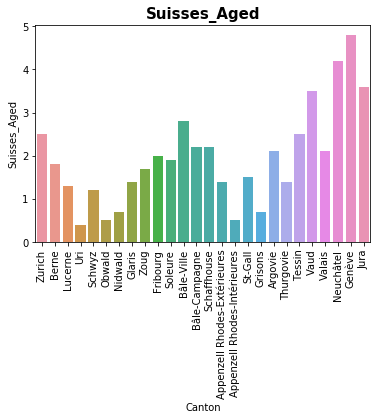

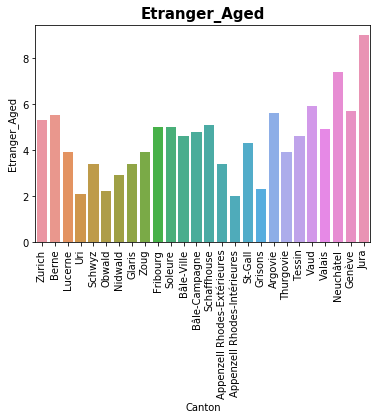

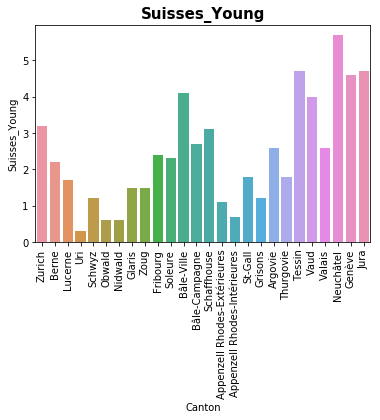

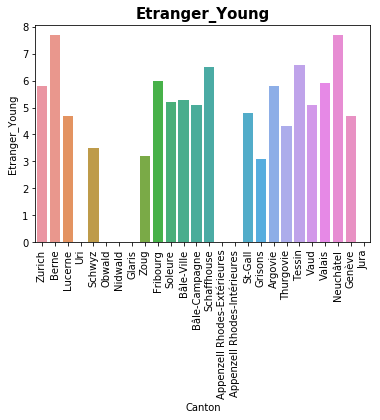

In [49]:
def plotBarChart(df, column):
    fig, ax = plt.subplots()
    ax.set_title(column, fontsize=15, fontweight='bold')
    sns.barplot(suisse['Canton'].keys(), suisse[column], ax=ax)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.show()

plotBarChart(suisse, 'Suisses_Aged') 
plotBarChart(suisse, 'Etranger_Aged')
plotBarChart(suisse, 'Suisses_Young')
plotBarChart(suisse, 'Etranger_Young')

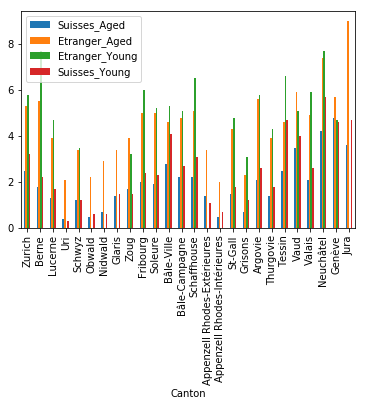

In [50]:
suisse.plot.bar()
plt.show()